In [1]:
import os
from pathlib import Path
from cotnav.models.vlms import infer_registry
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# model_name = "o3"
# model_name = "o4-mini"
# model_name = "gpt-5"
# model_args = {
#     "reasoning": {"effort": "low"},
#     "text": {"verbosity": 'low'},
#     "tools": [{"type": "code_interpreter", "container": {"type": "auto"}}],
#     # "max_output_tokens": 384,
# }

model_name = "gpt-4o-mini"
model_args = {
    # "text": {"verbosity": 'medium'},
    "tools": [{"type": "code_interpreter", "container": {"type": "auto"}}],
    # "max_output_tokens": 384,
}

vlm_cfg = {
    "name": "openai",  # resolved by infer_registry.get(...)
    "provider_kwargs": {
        "model": model_name,
        "api_key": os.environ["OPENAI_API_KEY"],
        "timeout": 90.0,
        "service_tier": "standard",
        "default_model_args": model_args
    },
    "generate_defaults": {
        "instructions": "Answer concisely and focus on drivable-space cues."
    },
}

motion_cfg = {
    "max_curvature": 0.6,
    "max_free_path_length": 3.0,
    "num_options": 7,
    "pixels_per_meter": 120.0,
    "colors": [(255, 0, 0), (255, 255, 255), (0, 255, 0)],
    "thickness": 3,
    "endpoint_radius": 4,
    "alpha": 230,
}

annotation_cfg = {
    "thickness": 5,
    "endpoint_radius": 25,
    "overlay_alpha": 0.9,
    "label_font_size": 40,
    "label_font_color": (0, 0, 0),
}

In [3]:
pivot = infer_registry.get("pivot", vlm=vlm_cfg, motion_parameters=motion_cfg)


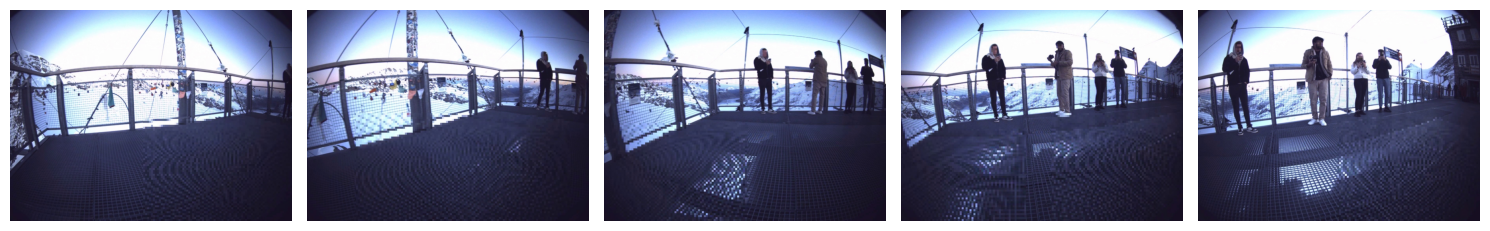

In [ ]:
%matplotlib inline
from decord import VideoReader
from decord import cpu, gpu
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

from cotnav.utils.math_utils import (interpolate_se3, se3_matrix, transform_poses)
from cotnav.utils.image_utils import (save_video)
from cotnav.utils.loader_utils import (load_intrinsics, load_odom, load_timestamps, build_transforms)
from cotnav.models.vlms.openaimodel import (
    ChatQuery, get_openai_cost
)

"""BEGIN USER PARAMS"""
MISSION = "mission_2024-11-02-17-18-32"
START_FRAME = 477
END_FRAME = 517
FRAME_STEP = 1
LANGUAGE_CMD = "Go to the back entrance of the building."
ENABLE_CONDITIONAL = True
"""END USER PARAMS"""

mission_dir = Path(f"/robodata/arthurz/Research/cotnav/data/grandtour_raw/{MISSION}")
video_path = mission_dir / "front_camera_lossy.mp4"
ts_path   = mission_dir / "front_camera_timestamps_anymal.csv"
odom_path = mission_dir / "odometry_data_anymal.csv"
info_path = mission_dir / "front_camera_info_anymal.yaml"
tf_path = mission_dir / "tf_static_anymal.yaml"

assert all(p.exists() for p in [mission_dir, video_path, odom_path, info_path, ts_path, tf_path]), "One or more paths do not exist"

calib = load_intrinsics(info_path, tf_path, world_frame="base")

vr = VideoReader(str(video_path), ctx=cpu(0))
batch = vr.get_batch(np.arange(START_FRAME, END_FRAME, FRAME_STEP))
frames = batch.asnumpy()

plt.figure(figsize=(15, 6))
num_plots = 5
frame_indices = np.linspace(0, len(frames) - 1, num_plots, dtype=int)
for i, idx in enumerate(frame_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Write batch to video file
save_video(frames, "test_output.mp4", fps=10)

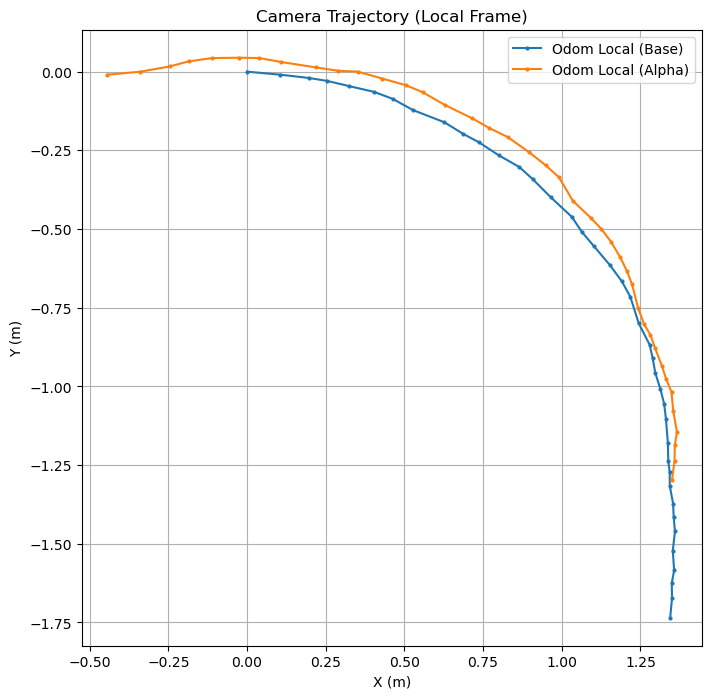

(40, 3)


In [5]:
# Load odometry and convert to local frame
odom = load_odom(odom_path)
cam_ts = load_timestamps(ts_path)
interp_odom = interpolate_se3(cam_ts, odom[:, 0], odom[:, 1:4], odom[:, 4:8])

tm = build_transforms(tf_path)
odom_window = odom[START_FRAME:min(END_FRAME, len(odom))]
T_hesai_odom = se3_matrix(odom_window[:, 1:4], odom_window[:, 4:8])
T_base_hesai = tm.get_transform("hesai_lidar", "base") # tgt, src
T_base_odom = T_hesai_odom @ T_base_hesai
T_base_local = np.linalg.inv(T_base_odom[0]) @ T_base_odom
p_base_local = T_base_local[:, :3, 3]

T_alpha_base = tm.get_transform("base", "alphasense_front_center") # tgt, src

p_alpha_base = -T_alpha_base[:3, 3]
p_alpha_base_homo = np.hstack((p_alpha_base, 1))
p_alpha_local = T_base_local @ p_alpha_base_homo.T
p_alpha_local = p_alpha_local[:, :3]

# Transform odom poses from world to local frame (base)
plt.figure(figsize=(8, 8))
plt.plot(p_base_local[:, 0], p_base_local[:, 1], marker='o', markersize=2, label='Odom Local (Base)')
plt.plot(p_alpha_local[:, 0], p_alpha_local[:, 1], marker='o', markersize=2, label='Odom Local (Alpha)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Camera Trajectory (Local Frame)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

print(p_alpha_local.shape)

In [6]:
# Compute goal heading angle
def heading_from_start(poses: np.ndarray, start_idx: int, goal_idx: int, *, degrees=False) -> float:
    """
    Compute signed heading angle from the robot's start pose (4x4 SE3) to the goal.
    Positive = CCW from robot's +x axis in the start frame.
    """
    if poses.shape[1:] != (4, 4):
        raise ValueError(f"poses must be 4x4 SE(3) matrix, found {poses.shape[1:]}")

    goal_xyz = poses[goal_idx, :3, 3].reshape(-1)
    if goal_xyz.size not in (2,3):
        raise ValueError("goal_xyz must have 2 or 3 entries (x,y[,z])")
    T_start = poses[start_idx]

    # Start pose world position & yaw
    x0, y0 = T_start[0,3], T_start[1,3]
    R_start = T_start[:3,:3]
    yaw0 = R.from_matrix(R_start).as_euler("zyx", degrees=False)[0]

    # World bearing to goal
    gx, gy = goal_xyz[0], goal_xyz[1]
    bearing_world = np.arctan2(gy - y0, gx - x0)

    # Relative heading = bearing - start_yaw
    heading = (bearing_world - yaw0 + np.pi) % (2*np.pi) - np.pi
    return np.degrees(heading) if degrees else heading

goal_hdg_deg = heading_from_start(T_base_local, 0, -1, degrees=True)  # degrees
print("Goal Heading (deg): ", goal_hdg_deg)
print("T_base_local shape ", T_base_local.shape)
print("Frames shape: ", frames.shape)

Goal Heading (deg):  -52.225546506511634
T_base_local shape  (40, 4, 4)
Frames shape:  (40, 1080, 1440, 3)


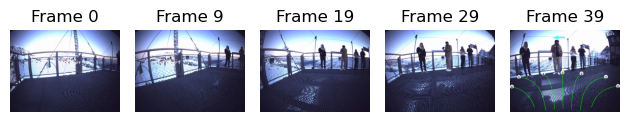

2025-10-08 09:31:08,320 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-08 09:31:09,036 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-08 09:31:09,777 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-08 09:31:10,476 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-08 09:31:11,111 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-08 09:31:48,402 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-10-08 09:31:48,519 - INFO - Cost for step 0: $0.010781
2025-10-08 09:31:48,520 - INFO - Cost breakdown: {'input_cost': 0.01039905, 'cached_cost': 0.0, 'output_cost': 0.00038219999999999997}
2025-10-08 09:31:48,521 - INFO - Total cost: $0.010781


Stage response str  {
  "decisions": [
    {
      "choice": 0,
      "reason": "Path appears obstructed, likely not a safe or clear route."
    },
    {
      "choice": 1,
      "reason": "Opening visible but may lead to a more complicated route."
    },
    {
      "choice": 2,
      "reason": "Direct route under observation; may be crowded."
    },
    {
      "choice": 3,
      "reason": "Potential for a clear path but unclear obstacles ahead."
    },
    {
      "choice": 4,
      "reason": "Moderate risk with possible obstruction; still viable."
    },
    {
      "choice": 5,
      "reason": "Likely the safest route as others are blocking alternate paths."
    },
    {
      "choice": 6,
      "reason": "Paths appear complicated and could lead to dead ends."
    },
    {
      "choice": 5,
      "reason": "This path is the least obstructed and likely the safest option."
    }
  ]
}


In [7]:
# %pdb
import json
import logging 
from PIL import Image

intermediate_prompts = []
if not ENABLE_CONDITIONAL:
    # Response gathering loop
    with open("/robodata/arthurz/Research/cotnav/cotnav/models/prompts/parallel_prompt.txt", "r") as f:
        system_prompt = f.read()

    intermediate_prompts = [
        f"""
        For each path option from 0 to 6, describe how promising of an option it is for {LANGUAGE_CMD} and provide each reason for each choice in a list of json objects. After describing each path option, then append one more choice in the list of json objects for best path option and the reason. ONLY output the result in the format as described in the system prompt.
        """
    ]
else:
    with open("/robodata/arthurz/Research/cotnav/cotnav/models/prompts/conditional_prompt.txt", "r") as f:
        system_prompt = f.read()

    intermediate_prompts = [
        f"""
        For each path option from 0 to 6, describe how promising of an option it is for {LANGUAGE_CMD} and provide each reason for each choice in a list of json objects. ONLY output the result in the format as described in the system prompt.
        """,
        f"""
        Given the previous reasons explaining each path option, select the best overall choice that follows the {LANGUAGE_CMD} and its reason in a json format. ONLY output the result in the format as described in the system prompt.
        """
    ]

motion_arcs = pivot.motion_templates()

total_cost = 0
messages = []
intermediate_responses = []

images = []
plt.figure()
for i, frame_idx in enumerate(frame_indices):
    frame = Image.fromarray(frames[frame_idx])
    if i == len(frame_indices) - 1:
        frame, centers = pivot.annotate_constant_curvature(
            frame, arcs=motion_arcs, calib=calib, **annotation_cfg
        )
        goal_hdg_deg = heading_from_start(T_base_local, frame_idx, -1, degrees=True)
        frame = pivot.annotate_goal_heading(frame, goal_hdg_deg)
        annotated_frame = frame.copy()
    images.append(ChatQuery("image", "user", frame))

    # Plot all frames side by side on the same figure
    plt.subplot(1, len(frame_indices), i + 1)
    plt.imshow(np.array(frame))
    plt.axis('off')
    plt.title(f"Frame {frame_idx}")
plt.tight_layout()
plt.show()

annotated_frame = None
messages.extend(images)
for i, prompt in enumerate(intermediate_prompts):
    # Add user prompt and query VLM
    messages.append(ChatQuery("text", "user", prompt))
    response = pivot.vqa(system_prompt, messages)

    # Parse output and add to messages
    response_output_str = json.dumps(response.output_parsed.model_dump(), ensure_ascii=False, indent=2)
    stage_response = ChatQuery("text", "assistant", response_output_str)
    messages.append(stage_response)
    intermediate_responses.append(response_output_str)
    print("Stage response str ", response_output_str)
    cost, cost_breakdown = get_openai_cost(
        model_name,
        response.usage.input_tokens - response.usage.input_tokens_details.cached_tokens,
        response.usage.input_tokens_details.cached_tokens,
        response.usage.output_tokens
    )
    total_cost += cost
    logging.info(f"Cost for step {i}: ${cost:.6f}")
    logging.info(f"Cost breakdown: {cost_breakdown}")
logging.info(f"Total cost: ${total_cost:.6f}")

In [8]:
# print("Intermediate Responses:", len(intermediate_responses), intermediate_responses)
# output = json.loads(intermediate_responses)
# print(output)

import json
from typing import Any, Dict, List

def convert_response_to_unified_format(
    response_json: Any,
    dataset: str,
    mission: str,
    start_frame: int,
    end_frame: int,
    conditional_enabled: bool,
) -> Dict[str, Any]:
    """Convert VLM output(s) to the unified format."""

    # --- small coercers ---
    def coerce(obj: Any) -> Any:
        # pydantic -> dict
        try:
            from pydantic import BaseModel  # type: ignore
            if isinstance(obj, BaseModel):
                return obj.model_dump()
        except Exception:
            pass
        # str -> json
        if isinstance(obj, str):
            try:
                return json.loads(obj)
            except Exception:
                return obj
        return obj

    def as_decisions(x: Any) -> List[Dict[str, Any]]:
        x = coerce(x)
        if isinstance(x, dict) and "decisions" in x:
            return list(coerce(x["decisions"]))
        if isinstance(x, list):
            return list(x)
        raise ValueError("Expected a list or a dict with key 'decisions'.")

    def to_choice_reason(d: Any) -> Dict[str, Any]:
        d = coerce(d) or {}
        # print("D" , d)
        # accept {choice, reason} or {final_choice, final_reason}
        choice = d.get("choice", d.get("final_choice", None))
        reason = d.get("reason", d.get("final_reason", ""))
        # normalize choice to int when possible
        try:
            choice = int(choice)
        except Exception:
            pass
        return {"choice": choice, "reason": str(reason)}

    data = coerce(response_json)

    out = {
        "dataset": dataset,
        "mission": mission,
        "start_frame": start_frame,
        "end_frame": end_frame,
        "intermediate_responses": [],
        "final_response": {"stage": 0, "choice": None, "reason": ""},
    }

    if conditional_enabled:
        # Expect [decisions_stage0, final_dict]
        if not (isinstance(data, list) and len(data) >= 2):
            raise ValueError("Conditional mode expects [decisions_list, final_dict].")
        stage0 = as_decisions(data[0])
        final_dict = to_choice_reason(as_decisions(data[-1])[0])
        out["intermediate_responses"] = [
            {"stage": 0, **to_choice_reason(d)} for d in stage0
        ]
        out["final_response"] = {"stage": 0, **final_dict}
    else:
        # Expect a single list (or dict with 'decisions'); last element is final
        decs = [to_choice_reason(d) for d in as_decisions(data[0])]
        if not decs:
            raise ValueError("Non-conditional mode requires a non-empty decisions list.")
        inter, final = decs[:-1], decs[-1]
        out["intermediate_responses"] = [{"stage": 0, **d} for d in inter]
        out["final_response"] = {"stage": 0, **final}

    return out


unified_response = convert_response_to_unified_format(
    response_json=intermediate_responses,   # list/str/pydantic per your pipeline
    dataset="grandtour",
    mission=MISSION,
    start_frame=START_FRAME,
    end_frame=END_FRAME,
    conditional_enabled=ENABLE_CONDITIONAL,
)
print(json.dumps(unified_response, indent=2))

# print(intermediate_responses[-1])


{
  "dataset": "grandtour",
  "mission": "mission_2024-11-02-17-18-32",
  "start_frame": 477,
  "end_frame": 517,
  "intermediate_responses": [
    {
      "stage": 0,
      "choice": 0,
      "reason": "Path appears obstructed, likely not a safe or clear route."
    },
    {
      "stage": 0,
      "choice": 1,
      "reason": "Opening visible but may lead to a more complicated route."
    },
    {
      "stage": 0,
      "choice": 2,
      "reason": "Direct route under observation; may be crowded."
    },
    {
      "stage": 0,
      "choice": 3,
      "reason": "Potential for a clear path but unclear obstacles ahead."
    },
    {
      "stage": 0,
      "choice": 4,
      "reason": "Moderate risk with possible obstruction; still viable."
    },
    {
      "stage": 0,
      "choice": 5,
      "reason": "Likely the safest route as others are blocking alternate paths."
    },
    {
      "stage": 0,
      "choice": 6,
      "reason": "Paths appear complicated and could lead to dead 

/tmp/ipykernel_1320781/1973900957.py:148: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05)  # minimal gap between panels
/tmp/ipykernel_1320781/1973900957.py:204: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


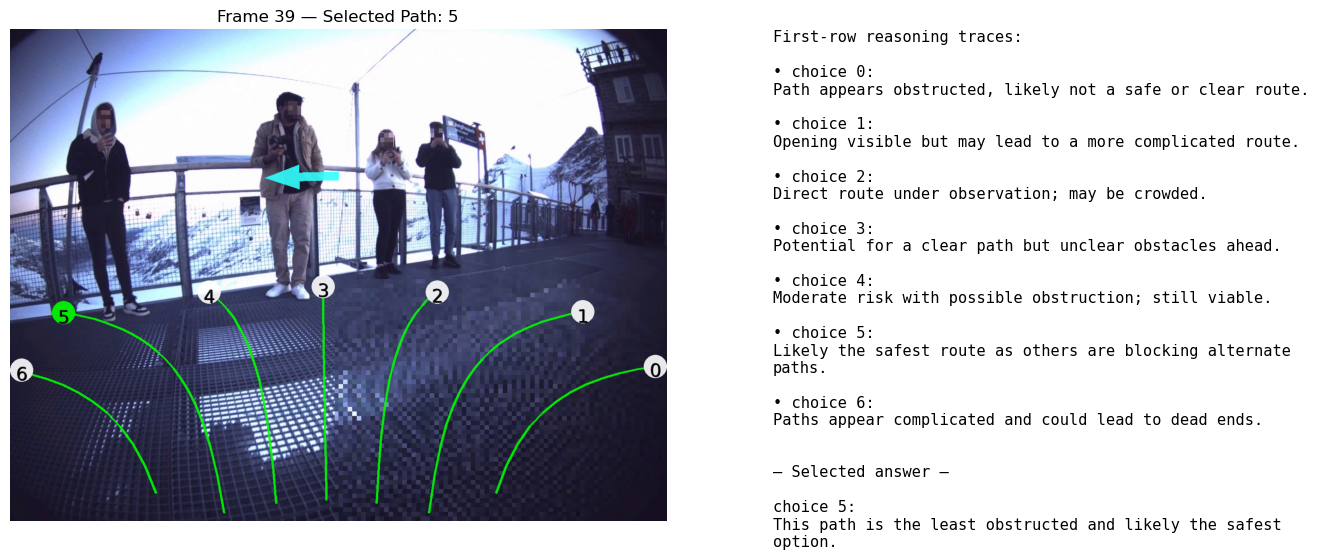

In [9]:
import re, math, cv2, textwrap, json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from PIL import ImageDraw
from cotnav.geometry.camera import project_to_pixel

BLUE = (50, 120, 255, 255)  # RGBA for PIL drawing
GREEN = (0, 255, 0)         # BGR for cv2 small circles etc.

def _sample_arc_xy(arc, max_len_m: float, samples_per_meter: int = 10) -> np.ndarray:
    s_end = float(min(max_len_m, getattr(arc, "length", max_len_m)))
    n = max(2, int(samples_per_meter * max(0.05, s_end)))
    s_vals = np.linspace(0.0, s_end, n)
    return np.array([arc.xy_at_s(float(s)) for s in s_vals], dtype=np.float32)

def _draw_polyline_rgba(pil_img, pts_uv, color_rgba=BLUE, thickness=5):
    draw = ImageDraw.Draw(pil_img)
    for a, b in zip(pts_uv[:-1], pts_uv[1:]):
        draw.line([a, b], fill=color_rgba, width=int(thickness))
    return pil_img

def _project_polyline_uv(xy_local: np.ndarray, calib, z_base: float = -0.4):
    """xy_local: (N,2) in base/local; returns list[(u,v)] of visible pixel ints."""
    if xy_local is None or xy_local.size == 0 or calib is None:
        return []

    xyz = np.c_[xy_local, np.full((xy_local.shape[0], 1), z_base, dtype=np.float32)]
    out = project_to_pixel(xyz, calib)
    if out is None:
        return []

    # Some versions return (uv, vis); others return uv only.
    if isinstance(out, tuple) and len(out) == 2:
        uv, vis = out
        if uv is None:
            return []
        if vis is None:
            vis = np.ones((uv.shape[0],), dtype=bool)
    else:
        uv = out
        if uv is None:
            return []
        vis = np.ones((uv.shape[0],), dtype=bool)

    uv = np.asarray(uv)
    vis = np.asarray(vis, dtype=bool)
    if uv.ndim != 2 or uv.shape[1] != 2:
        return []
    if vis.shape[0] != uv.shape[0]:
        vis = np.ones((uv.shape[0],), dtype=bool)

    return [(int(u), int(v)) for (u, v), ok in zip(uv, vis) if ok]

def _gt_local_polyline_from_odom_corrected(
    interp_odom: np.ndarray, 
    T_base_local: np.ndarray, 
    i: int, 
    lookahead_m: float = 6.0
) -> np.ndarray:
    T_current_local = np.linalg.inv(T_base_local[i]) @ T_base_local
    p_local = T_current_local[:, :3, 3]
    xy_local = p_local[:, :2]
    future_segment = xy_local[i:]
    if len(future_segment) < 2:
        return future_segment
    deltas = np.diff(future_segment, axis=0)
    distances = np.sqrt((deltas**2).sum(axis=1))
    cum_distances = np.concatenate([[0.0], np.cumsum(distances)])
    cutoff_idx = int(np.searchsorted(cum_distances, lookahead_m, side="right"))
    cutoff_idx = max(1, min(cutoff_idx, len(future_segment)-1))
    return future_segment[:cutoff_idx+1]

def response_to_json(response: str):
    return json.loads(response)

# --------- NEW: Parsing for the expected format ----------
def _parse_new_reasoning_format(obj):
    """
    Expects:
    {
      "dataset": "...",
      "mission": "...",
      "start_frame": int,
      "end_frame": int,
      "intermediate_responses": [{"stage": int, "choice": int, "reason": str}, ...],
      "final_response": {"stage": int, "choice": int, "reason": str}
    }
    Returns (intermediate_list, final_choice, final_reason)
    """
    if not isinstance(obj, dict):
        raise ValueError("Input must be a dict matching the new reasoning format.")

    inter = obj.get("intermediate_responses", []) or []
    final = obj.get("final_response", {}) or {}
    final_choice = final.get("choice", None)
    final_reason = str(final.get("reason", "")).strip()
    return inter, final_choice, final_reason

# -------------------- FINAL FRAME ONLY --------------------
final_idx = int(frame_indices[-1])

# If your data blob is already a dict, use it directly; otherwise parse string JSON.
# Replace `structured_obj` with your variable holding the new-format dict.
# Example: structured_obj = response_to_json(raw_json_string)
intermediate_list, selected, selected_reason = _parse_new_reasoning_format(unified_response)

motion_arcs = pivot.motion_templates()

# Re-annotate with selected index so the chosen endpoint circle is GREEN
img_annot, _ = pivot.annotate_constant_curvature(
    frames[final_idx],
    arcs=motion_arcs,
    calib=calib,
    selected_idx=(int(selected) if selected is not None else None),
    **annotation_cfg
)

# ---- Draw GT path in BLUE (projected polyline) ----
gt_xy = _gt_local_polyline_from_odom_corrected(
    interp_odom, T_base_local, i=final_idx, lookahead_m=6.0
)
gt_uv = _project_polyline_uv(
    gt_xy, calib, z_base=float(annotation_cfg.get("z_base", -0.4))
)
if len(gt_uv) >= 2:
    img_annot = _draw_polyline_rgba(
        img_annot, gt_uv,
        color_rgba=BLUE,
        thickness=int(annotation_cfg.get("thickness", 4)) + 1
    )

# ---- Draw goal heading arrow ----
goal_hdg_deg = heading_from_start(T_base_local, final_idx, -1, degrees=True)
W, H = img_annot.size
img_annot = pivot.annotate_goal_heading(
    img_annot, goal_hdg_deg,
    center=(int(W*0.5), int(H*0.3))
)

# ---- PLOT: single 1x2 figure (image + traces with selected below) ----
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 6),
    gridspec_kw={'width_ratios': [3.5, 2]},
    constrained_layout=True
)

fig.subplots_adjust(wspace=0.05)  # minimal gap between panels

# Left: annotated image
ax_img = axes[0]
ax_img.imshow(img_annot)
ax_img.set_aspect('equal')   # preserve image ratio
ax_img.margins(0)
sel_txt = f"{selected}" if selected is not None else "-"
ax_img.set_title(f"Frame {final_idx} — Selected Path: {sel_txt}", fontsize=12, pad=6)
ax_img.axis("off")

# Right: grouped first row of traces (intermediate) + selected answer below
ax_txt = axes[1]
ax_txt.axis("off")
ax_txt.set_xlim(0, 1); ax_txt.set_ylim(0, 1)  # stable coord system for text

# Group (right): intermediate traces
lines = []
if intermediate_list:
    lines.append("First-row reasoning traces:\n")
    for d in intermediate_list:
        ch = d.get("choice", "-")
        rs = str(d.get("reason", "")).strip()
        wrapped = textwrap.fill(rs, width=60)
        # Just bullets for the group
        lines.append(f"• choice {ch}:\n{wrapped}\n")
else:
    lines.append("(no intermediate responses)\n")

# Divider + final selection below
lines.append("\n— Selected answer —\n")
final_block = f"choice {sel_txt}:\n{textwrap.fill(selected_reason, width=60) if selected_reason else '(no reason)'}"
lines.append(final_block)

ax_txt.text(
    0.0, 1.0,
    "\n".join(lines),
    va="top", ha="left",
    fontsize=11,
    family="monospace",
    transform=ax_txt.transAxes   # << key: use axes coords
)

# Prepare output directory
out_dir = Path(f"output/{MISSION}/seq_{START_FRAME}_{END_FRAME}")
out_dir.mkdir(parents=True, exist_ok=True)

mode = "conditional" if ENABLE_CONDITIONAL else "parallel"
json_path = out_dir / f"{mode}_output.json"
img_path = out_dir / f"{mode}_output.png"

# Save JSON
with open(json_path, "w") as f:
    json.dump(unified_response, f, indent=2)

# Save matplotlib figure (last shown)
plt.tight_layout()
plt.savefig(img_path, bbox_inches="tight")
plt.show()
